<h1><center>COVID-19. Детекция Атипичной пневмонии по рентгеновским снимкам</center></h1>

<center><img src = "https://ichef.bbci.co.uk/news/800/cpsprodpb/1EA6/production/_110764870_coronavirusmedium.jpg.webp" width = "750" height = "500"/></center>

<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:blue; border:0; color:white' role="tab" aria-controls="home"><center>[Трнировка Модели]</center></h2>

### Ссылки

[Detectron_offical](https://github.com/facebookresearch/detectron2)

[VinBigData detectron2](https://www.kaggle.com/corochann/vinbigdata-detectron2-train)

[Detectron2 Tutorial](https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5#scrollTo=QHnVupBBn9eR)

В качестве фреймворка я выбрал Detectron2 по ряду причин:

    - Субъективно нравится
    - Понятный мануал
    - Неплохие результаты ( пробовал его в соревновании на Кагле)
    - Возможность гибкой настройки обучения

**DETECTRON2**

Detectron2 - это система нового поколения от Facebook AI Research, реализующая самые современные алгоритмы обнаружения объектов.

# Импорт Библиотек

In [1]:
import numpy as np 
import pandas as pd 
from datetime import datetime
import time
from tqdm import tqdm_notebook as tqdm # progress bar
import matplotlib.pyplot as plt

import os, json, cv2, random
import skimage.io as io
import copy
import pickle
from pathlib import Path
from typing import Optional

import torch

# Albumenatations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import warnings

import config
from COVID19_dict import build_COVID19_data_dicts

In [2]:
# detectron2
from detectron2.structures import BoxMode
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultPredictor, DefaultTrainer, launch
from detectron2.evaluation import COCOEvaluator
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer

from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data import detection_utils as utils


from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

setup_logger()

<Logger detectron2 (DEBUG)>

In [3]:
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('ggplot')

# Загрузка данных

In [4]:
imdir = f'{config.DATA_ROOT_RESIZED}/img_sz_640'
# Загрузим CSV полученный в ноутбуке с EDA
train_df = pd.read_csv(f'{config.DATA_ROOT}/train_image_df.csv')
print(f'Number of studies: {len(train_df)}')

Number of studies: 6334


## Configs

In [5]:
classes = [
    "atypical",
    "indeterminate",
    "negative",
    "typical"
]

debug=False
split_mode="valid20" # Or  "all_train"

category_name_to_id = {
    class_name: index for index, class_name in enumerate(classes)
}

print(category_name_to_id)

{'atypical': 0, 'indeterminate': 1, 'negative': 2, 'typical': 3}


<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:orange; border:0; color:white' role="tab" aria-controls="home"><center>[Подготовка данных]</center></h2>

Для определения кстомного датасета, нам нужно создать **список словарей** (dataset_dicts) где каждый словарь содержит:

 - file_name: имя файла изображения
 - image_id: id изображения, (он же индекс).
 - height: высота изображения.
 - width: Ширина изображения.
 - annotation: основные аннотационные данные для обнаружения объектов, которые содержат следующее:
   - bbox: bounding box pixel location имеющий shape n_boxes,4
   - bbox_mode: Тут тспользуется BoxMode.XYXY_ABS. Абсолютное значение (x_min, y_min, x_max, y_max) аннотаций используется в bbox
   - category_id: class label id for each bounding box, with shape (n_boxes,)


*build_COVID19_data_dicts* для подготовки тренировочных даных
*build_COVID19_data_dicts* c аргументом *test* для подготовки тестовых даных

Этот *dataset_dicts* содержит метаданные для фактических данных, передаваемых в нейронную сеть.
Он загружается перед обучением в памяти, поэтому он должен содержать все метаданные (путь к файлу изображения и т. д.) для создания набора обучающих данных, но не должен содержать **тяжелые данные**. 

На практике загрузка всех связанных массивов изображений слишком велика для загрузки в память, поэтому они загружаются внутри DataLoader по требованию (Это делается при помощи класса *mapper в detectron2*

In [6]:
if split_mode == "all_train":
    print("selected split mode is ALL_TRAIN")
    DatasetCatalog.register(
        "COVID19_data_train",
        lambda: get_COVID19_data_dicts(
            imgdir,
            train_df,
            debug=debug,
            data_type="train",
            cache_mode='All'
        ),
    )
    MetadataCatalog.get("COVID19_data_train").set(thing_classes=classes)
    
    
    dataset_dicts_train = DatasetCatalog.get("COVID19_data_train")
    metadata_dicts_train = MetadataCatalog.get("COVID19_data_train")
    
elif split_mode == 'valid20':
    print("selected split mode is valid20'")
    n_dataset = len(
        build_COVID19_data_dicts(
            imdir,
            train_df,
            debug=debug,
            data_type = 'train',
            cache_mode='All'
        )
    )
    n_train = int(n_dataset * 0.90)
    print(f'All_dataset_size: {n_dataset}, train_dataset_size: {n_train}')
    rs = np.random.RandomState(42)
    inds = rs.permutation(n_dataset)
    train_inds, valid_inds = inds[:n_train], inds[n_train:]
    # Регестрируем тренировочный датасет
    DatasetCatalog.register(
        "COVID19_data_train",
        lambda: build_COVID19_data_dicts(
            imdir,
            train_df,
            target_indices=train_inds,
            debug=debug,
            data_type="train",
            cache_mode='train'
        ),
    )
    MetadataCatalog.get("COVID19_data_train").set(thing_classes=classes)
    # Регестрируем валидационный датасет
    DatasetCatalog.register(
        "COVID19_data_valid",
        lambda: build_COVID19_data_dicts(
            imdir,
            train_df,
            target_indices=train_inds,
            debug=debug,
            data_type="train",
            cache_mode='val'
        ),
    )
    MetadataCatalog.get("COVID19_data_valid").set(thing_classes=classes)
    
    dataset_dicts_train = DatasetCatalog.get("COVID19_data_train")
    metadata_dicts_train = MetadataCatalog.get("COVID19_data_train")
    
    dataset_dicts_valid = DatasetCatalog.get("COVID19_data_valid")
    metadata_dicts_valid = MetadataCatalog.get("COVID19_data_valid")
    
else:
    raise ValueError(f"[ERROR] Unexpected value split_mode={split_mode}")

selected split mode is valid20'
Creating the data ==> ...
image shape: (640, 640, 3)


100%|█████████████████████████████████████████████████████████████████████████| 6334/6334 [00:10<00:00, 622.76it/s]


Load from cache dataset_dicts_cache_All.pkl
All_dataset_size: 6334, train_dataset_size: 5700
Creating the data ==> ...
image shape: (640, 640, 3)


100%|█████████████████████████████████████████████████████████████████████████| 6334/6334 [00:10<00:00, 621.86it/s]


Load from cache dataset_dicts_cache_train.pkl
Creating the data ==> ...
image shape: (640, 640, 3)


100%|█████████████████████████████████████████████████████████████████████████| 6334/6334 [00:10<00:00, 624.68it/s]


Load from cache dataset_dicts_cache_val.pkl


# Визуализация данных

Detectron2 в своем арсенале имеет инструменты по визуализации. Это упрощает нам жизнь. Для получения таких же изображений в ноутбуке  Анализа данных была написана не одна громоздкая функция и не одна клавиатура была сломана 😂. 

В детектроне же есть класс Visualizer

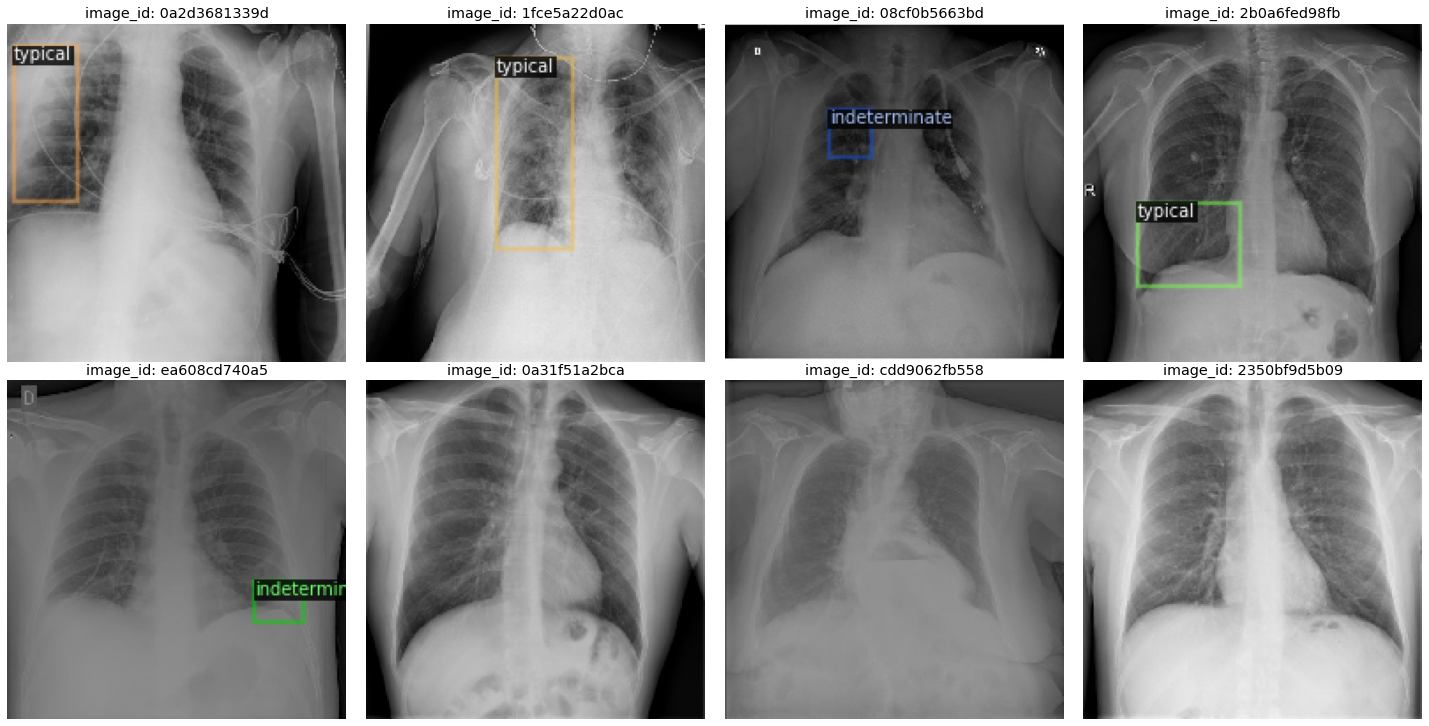

In [23]:
fig, ax = plt.subplots(2, 4, figsize =(20,10))
indices=[ax[0][0],ax[1][0],ax[0][1],ax[1][1],ax[0][2],ax[1][2],ax[0][3],ax[1][3]]
i=-1
for d in random.sample(dataset_dicts_train, 8):
    i+=1    
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1],
                   metadata=metadata_dicts_train, 
                   scale=0.3, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_dataset_dict(d)
    indices[i].grid(False)
    indices[i].axis('off')
    indices[i].set_title(f'image_id: {d["image_id"]}')
    indices[i].imshow(out.get_image()[:, :, ::-1])
plt.tight_layout(pad=0.5)

# DATALOADER

Detectron2 содержит в себе 2 встроенных пайплайна загрузки данных. build_detection_{train,test}_loader 
 - [ref : detectron2 docs "Dataloader"](https://detectron2.readthedocs.io/en/latest/tutorials/data_loading.html)

